# Random sampling of parameters

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [13]:
import os
import itertools
import pickle
import cloudpickle
import re
import glob
import git

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns
# Increase DPI of displayed figures
%config InlineBackend.figure_format = 'retina'

# Import the project utils
import ccutils

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Define directories for data and figure 
figdir = f'{homedir}/fig/MaxEnt_approx_joint/'
datadir = f'{homedir}/data/csv_maxEnt_dist'

In [3]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{var}[1]{\text{Var}\left( #1 \right)}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{\text{th}}$

## Variability in the kinetic parameters

An idea that could explain the systematic variation between our theoretical predictions and the data is the stochasticity that could be associated with random variation of the kinetic parameters. For example, if cells happen to stochastically have different number of ribosomes, how much would that affect the final distribution. Another good example is the variability in repressor copy number, which would affect the $\kron$ rate.

To simplify things what we will do is sample random variations to some of the kinetic parameters, run the dynamics with such parameters, and then reconstruct the corresponding MaxEnt distribution. Then we will combine all of these distributions to see how different this is compared to the one with single parameter values.

### Unregulated promoter parameter variation

Let's begin with the unregulated promoter. The parameters here are $\kpon, \kpoff, r_m, \gm, r_p$, and $\gp$. The simplest scenario would be to sample variations out of a Gaussian distribution. We will set these distributions to be centered at the current value of the parameter we are using, and allow a variation of some defined percentage.

Let's define a function that given an array of parameters, it samples random variations.

In [8]:
def param_normal_sample(param, n_samples, std=0.2):
    '''
    Function that samples variations to the parameter values out of a normal
    distribution.
    Parameters
    ----------
    param : array-like.
        List of parameters from which the samples will be generated.
    n_samples : int.
        Number or random samples to draw from the distribution
    std : float or array-like.
        Fractional standard deviations for each of the samples to be taken. 
        If a single value is given, then all of the distributions will have 
        the same standard deviation proportional to the mean.
        
    Returns
    -------
    samples : array-like. Shape = len(param) x n_samples
        Random samples of the parameters.
    '''
    # Initialize array to save output
    samples = np.zeros([n_samples, len(param)])
    
    # Loop through parameters
    for i, par in enumerate(param):
        if len(std) == len(param):
            samples[:, i] = np.random.normal(par, par * std[i], n_samples)
        elif len(std) == 1:
            samples[:, i] = np.random.normal(par, par * std[0], n_samples)
            
    return samples

Let's now load the parameters and generate random samples.

In [78]:
# Load parameter values
par = ccutils.model.load_constants()

# Define parametesr for unregulated promoter
par_names = ['kp_on', 'kp_off', 'rm', 'gm', 'rp']
param = [par[x] for x in par_names]

# Generate samples of all parameters with a 10% variability
n_samples = 999 
std = [0.15]
param_sample = param_normal_sample(param, n_samples, std)
# Add reference parameters to list
param_sample = np.append(np.array([[*param]]), param_sample, axis=0)

Having sampled the parameters let's go ahead and run the dynamics for each of these parameter sets. First we need to load the matrix to compute the moments of the distribution after the cell division as a function of the moments before the cell division.

In [79]:
# Read matrix into memory
with open(f'{homedir}/src/theory/pkl_files/binom_coeff_matrix.pkl', 
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    Z_mat = unpickler.load()
    expo_binom = unpickler.load()

Now let's load the matrix to compute the dynamics of the unregualted two-state promoter

In [80]:
with open('../pkl_files/two_state_protein_dynamics_matrix.pkl',
          'rb') as file:
    A_mat_unreg_lam = cloudpickle.load(file)
    expo_unreg = cloudpickle.load(file)

Next let's define all of the parameters that we will need for the integration.

In [81]:
# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
t_single = 60 * t_single_frac * doubling_time # sec
t_double = 60 * (1 - t_single_frac) * doubling_time # sec
n_cycles = 6

# Define names for dataframe columns
names = par_names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in expo_unreg]

# Initialize DataFrame to save constraints
df_moments = pd.DataFrame([], columns=names)

Now we are ready to run the dynamics in parallel, let's define the function so that we can perform this numerical integration in parallel

In [109]:
compute_dynamics = False

if compute_dynamics:
    # Define function for parallel computation
    def constraints_parallel(par):
        kp_on = par[0]
        kp_off = par[1]
        rm = par[2]
        gm = par[3]
        rp = par[4]

        # Single promoter
        gp_init = 1 / (60 * 60)
        rp_init = 500 * gp_init

        # Generate matrices for dynamics
        # Single promoter
        par_unreg_s = [kp_on, kp_off, rm, gm, rp, 0]
        # Two promoters
        par_unreg_d = [kp_on, kp_off, 2 * rm, gm, rp, 0]

        # Initial conditions
        A_unreg_s_init = A_mat_unreg_lam(
            kp_on, kp_off, rm, gm, rp_init, gp_init
        )

        # Define initial conditions
        mom_init = np.zeros(len(expo_unreg) * 2)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(
            ccutils.model.rhs_dmomdt, mom_init, t, args=(A_unreg_s_init,)
        )
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = ccutils.model.dmomdt_cycles(
            m_init,
            t_single,
            t_double,
            A_mat_unreg_lam,
            par_unreg_s,
            par_unreg_d,
            expo_unreg,
            n_cycles,
            Z_mat,
            states=["A", "I"],
            n_steps=3000,
        )

        # Keep only last cycle
        df = df[df["cycle"] == df["cycle"].max()]

        # Extract time of last cell cycle
        time = np.sort(df["time"].unique())

        # Compute the time differences
        time_diff = np.diff(time)
        # Compute the cumulative time difference
        time_cumsum = np.cumsum(time_diff)
        time_cumsum = time_cumsum / time_cumsum[-1]

        # Define array for spacing of cell cycle
        a_array = np.zeros(len(time))
        a_array[1:] = time_cumsum

        # Compute probability based on this array
        p_a_array = np.log(2) * 2 ** (1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(expo_unreg):
            # Generate string that finds the moment
            mom_name = "m" + str(mom[0]) + "p" + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array, a_array))

        # Save results into series in order to append it to data frame
        series = pd.Series(list(par) + moms, index=names)

        return series

    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(
        delayed(constraints_parallel)(par) for par in param_sample
    )

    # Initialize data frame to save list of pareters
    df_moments = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_moments = df_moments.append(s, ignore_index=True)
    df_moments.to_csv(
        f"{homedir}/data/csv_maxEnt_dist/" + "MaxEnt_unreg_random.csv",
        index=False,
    )

df_moments = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/" + "MaxEnt_unreg_random.csv"
)
df_moments.head()

,kp_on,kp_off,rm,gm,rp,m0p0,m1p0,m2p0,m3p0,m4p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,0.035800,0.733642,1.428638,0.005556,0.057687,1.000001,15.465073,322.675799,8592.938264,278504.423656,...,7.435491e+11,2.400384e+14,9.106554e+16,4.227171e+19,1.023095e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007274e+23
1,0.032431,0.739528,1.393289,0.005057,0.053299,1.000000,14.931711,301.564644,7785.472725,244981.550660,...,5.395222e+11,1.606668e+14,5.630176e+16,2.419201e+19,7.836451e+10,1.808850e+13,4.694138e+15,1.393147e+18,4.844928e+20,2.053035e+23
2,0.033365,0.756140,1.506338,0.005693,0.051598,1.000001,14.460292,286.760352,7330.247698,229696.596719,...,4.462012e+11,1.259343e+14,4.219377e+16,1.756454e+19,6.879409e+10,1.487937e+13,3.636832e+15,1.023284e+18,3.403527e+20,1.397538e+23
3,0.032628,0.837036,1.691334,0.005508,0.062506,0.999998,14.887434,303.271975,7958.185306,255967.530435,...,7.484595e+11,2.556261e+14,1.035300e+17,5.198011e+19,9.785864e+10,2.563360e+13,7.586002e+15,2.582902e+18,1.038477e+21,5.143209e+23
4,0.039527,0.795206,1.198771,0.005553,0.055292,1.000000,13.212645,234.657643,5289.403937,144373.769725,...,3.067514e+11,9.590359e+13,3.507520e+16,1.562467e+19,3.641700e+10,8.908471e+12,2.439814e+15,7.604343e+17,2.761119e+20,1.213352e+23


Let's look at the distribution of means and standard deviations in mRNA count for these variations in parameters.

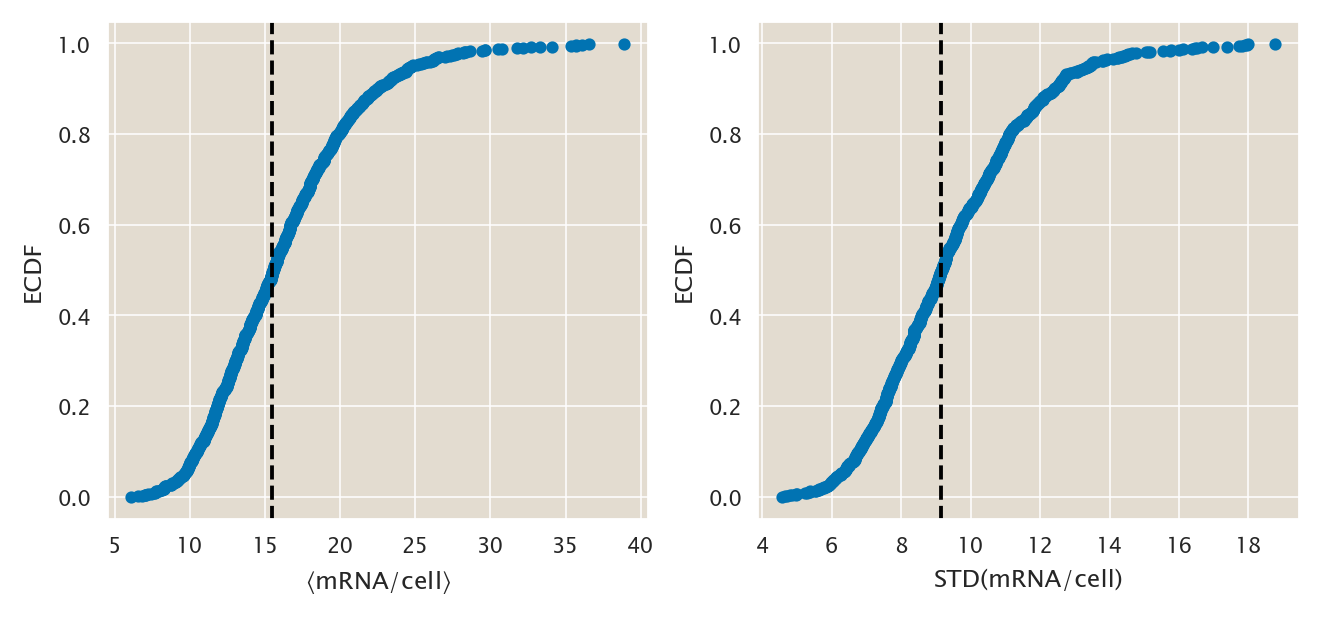

In [84]:
# Compute mRNA standard deviations
mRNA_std = np.sqrt(df_moments.m2p0 - df_moments.m1p0**2)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Generate ECDF for mean
x, y = ccutils.stats.ecdf(df_moments.m1p0)
ax[0].plot(x, y, lw=0, marker='.')
# add reference line
ax[0].axvline(df_moments.m1p0[0], color='black',
              linestyle='--')
# label axis
ax[0].set_xlabel(r'$\left\langle \right.$mRNA/cell$\left. \right\rangle$')
ax[0].set_ylabel('ECDF')

# Generate ECDF for standard deviation 
x, y = ccutils.stats.ecdf(mRNA_std)
ax[1].plot(x, y, lw=0, marker='.')
# add reference line
ax[1].axvline(mRNA_std[0], color='black', linestyle='--')
# label axis
ax[1].set_xlabel('STD(mRNA/cell)')
ax[1].set_ylabel('ECDF');

There is quite a lot of variability compared to the reference value. Let's repeat these plots, but this time for the protein values

Text(0, 0.5, 'ECDF')

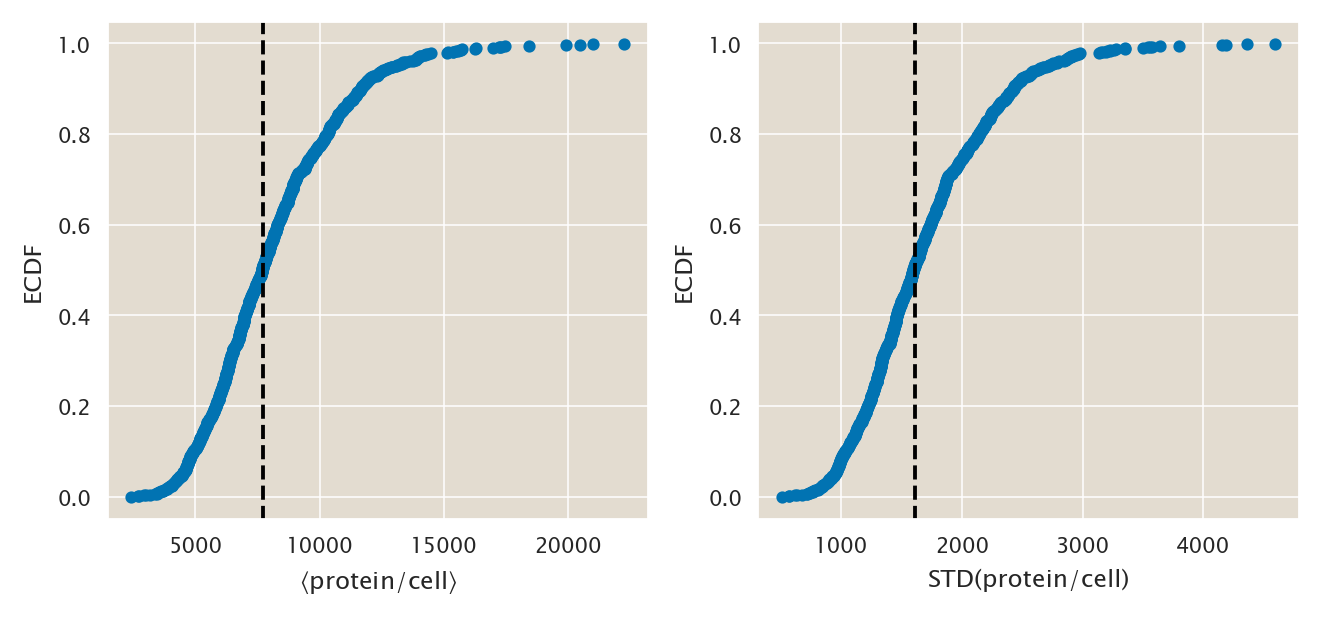

In [107]:
# Compute protein standard deviations
protein_std = np.sqrt(df_moments.m0p2 - df_moments.m0p1 ** 2)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Generate ECDF for mean
x, y = ccutils.stats.ecdf(df_moments.m0p1)
ax[0].plot(x, y, lw=0, marker=".")
# add reference line
ax[0].axvline(df_moments.m0p1[0], color="black", linestyle="--")
# label axis
ax[0].set_xlabel(r"$\left\langle \right.$protein/cell$\left. \right\rangle$")
ax[0].set_ylabel("ECDF")

# Generate ECDF for standard deviation
x, y = ccutils.stats.ecdf(protein_std)
ax[1].plot(x, y, lw=0, marker=".")
# add reference line
ax[1].axvline(protein_std[0], color="black", linestyle="--")
# label axis
ax[1].set_xlabel("STD(protein/cell)")
ax[1].set_ylabel("ECDF")

### Moments of the conditional distribution

Let's now compare the mean, variance and skewness of the resulting distribution. For this all we have to use is the so-called [law of total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation) that states that
$$
\ee{f(p)} = \ee{\ee{f(p) \mid \theta}_p}_\theta,
$$
i.e. to compute the expected value of the function $f(p)$ (could be something like $f(p) p^2$) we first compute the average of the function for a parameter set $\theta$, then we average the expected value of the function over all values of $\theta$.

Let's for example first compare the resulting mean protein copy numbers for the original value and the one that includes the variability

In [95]:
mean_delta = df_moments.m0p1[0]
mean_sample = df_moments.m0p1.mean()

print(f'mean delta: {np.round(mean_delta, 0)}')
print(f'mean sample: {np.round(mean_sample, 0)}')
print(f'fractional change: {(mean_sample - mean_delta) / mean_delta}')

mean delta: 7733.0
mean sample: 8075.0
fractional change: 0.04428981949722924


There is an increment of roughly a 4%, so that is pretty small. Let's now look at the variance

In [98]:
var_delta = df_moments.m0p2[0] - df_moments.m0p1[0]**2
var_sample = df_moments.m0p2.mean() - df_moments.m0p1.mean()**2

print(f'variance delta: {np.round(var_delta, 0)}')
print(f'variance sample: {np.round(var_sample, 0)}')
print(f'fractional change: {(var_sample - var_delta) / var_delta}')

variance delta: 2607605.0
variance sample: 10714739.0
fractional change: 3.1090341346727075


The change in the variance is quite large! Let's see how this reflects to the change in the noise (std/mean).

In [100]:
noise_delta = np.sqrt(var_delta) / mean_delta
noise_sample = np.sqrt(var_sample) / mean_sample

print(f'noise delta: {np.round(noise_delta, 2)}')
print(f'noise sample: {np.round(noise_sample, 2)}')

noise delta: 0.21
noise sample: 0.41


There is a factor of two of difference when computing the noise. That is quite interesting since that is exactly what we saw the systematic deviation in the data was like. Let's see what the change in the skewness is then.

In [105]:
skew_delta = (
    df_moments.m0p3[0] - 3 * mean_delta * var_delta - mean_delta ** 3
) / var_delta ** (3 / 2)

skew_sample = (
    df_moments.m0p3.mean() - 3 * mean_sample * var_sample - mean_sample ** 3
) / var_sample ** (3 / 2)

print(f"skewness delta: {np.round(skew_delta, 2)}")
print(f"skewness sample: {np.round(skew_sample, 2)}")

skewness delta: 0.71
skewness sample: 1.26


This is quite suggestive. It seems that the random variability